
#Import Necessary Libraries


In [1]:
from sklearn.svm import LinearSVC
import re
import nltk
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_validate

nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
 !pip install --upgrade gensim
 # I had to do this becuase it was givng me an error that nltk and gensim weren't working together.

In [3]:
import gensim
import numpy as np
from gensim.models import Word2Vec

# Reading in Data

In [6]:
#Importing trainging and testing data from computer
from google.colab import files
uploaded = files.upload()

Saving 1600_strat_samp_test.csv to 1600_strat_samp_test.csv
Saving 14400_strat_samp_training.csv to 14400_strat_samp_training.csv


In [7]:
#reading in training data
import pandas as pd
df = pd.read_csv("14400_strat_samp_training.csv")
#df.head()

#storing training reviews
review_text = df.loc[:, "review/text"]

#storing genres
genres = df.loc[:, "categories"]

#reading in testing data
df = pd.read_csv("1600_strat_samp_test.csv")

#storing testing reviews
test_review_text = df.loc[:, "review/text"]

#storing genres
test_genres = df.loc[:, "categories"]


# Pre-processing Text

In [8]:
#tokenize training reviews
tokenized_reviews = []

for i in review_text:
  tokText = nltk.word_tokenize(i)
  tokenized_reviews.append(tokText)

#tokenize test reviews
test_tokenized_reviews = []

for i in test_review_text:
  tokText = nltk.word_tokenize(i)
  test_tokenized_reviews.append(tokText)

In [9]:
#testing tokeinzation
print(tokenized_reviews[1000])
print(tokenized_reviews[5])

print(test_tokenized_reviews[1000])
print(test_tokenized_reviews[5])

['There', 'are', 'several', 'altered', 'versions', 'of', 'Thayer', "'s", 'classic', 'poem', 'in', 'existance.This', 'book', 'uses', 'one', 'of', 'them.I', 'love', 'this', 'poem', ',', 'and', 'I', 'wish', 'the', 'author', 'had', 'stuck', 'with', 'the', 'original.Especially', 'when', 'Ernest', 'Lawrence', 'Thayer', 'is', 'listed', 'as', 'the', 'author', '!', 'Also-', 'the', 'images', 'of', 'Casey', 'and', 'the', 'spectators', 'are', 'of', 'modernday', 'participants', '.', 'Casey', 'is', 'wearing', 'a', 'helmet', 'and', 'his', 'name', 'andnumber', 'are', 'on', 'the', 'back', 'of', 'his', 'uniform', '.', 'Not', 'like', 'a', 'playerin', '1888', 'at', 'all.Leroy', 'Neiman', 'is', 'a', 'great', 'artist', ',', 'and', 'that', 'is', 'the', 'only', 'reason', 'I', 'give', 'this2', 'stars', '.']
['It', "'s", 'very', 'difficult', 'to', 'look', 'up', 'anything', '--', 'you', 'have', 'be', 'able', 'to', 'decide', 'correctly', 'in', 'which', 'division', 'your', 'query', 'may', 'fit', '--', 'the', 'book

# Building Word2Vec Model

This code was taken from one of the labs.

In [10]:
!wget https://github.com/eyaler/word2vec-slim/raw/refs/heads/master/GoogleNews-vectors-negative300-SLIM.bin.gz

--2025-05-10 00:18:36--  https://github.com/eyaler/word2vec-slim/raw/refs/heads/master/GoogleNews-vectors-negative300-SLIM.bin.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/eyaler/word2vec-slim/refs/heads/master/GoogleNews-vectors-negative300-SLIM.bin.gz [following]
--2025-05-10 00:18:36--  https://media.githubusercontent.com/media/eyaler/word2vec-slim/refs/heads/master/GoogleNews-vectors-negative300-SLIM.bin.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276467217 (264M) [application/octet-stream]
Saving to: ‘GoogleNews-vectors-negative300-SLIM.bin.gz’

GoogleNews-vecto

In [11]:
bigmodel = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300-SLIM.bin.gz", binary=True)
print("big model loaded!")

big model loaded!


#Vectorize Reviews

In [12]:
#needed to average each review, so madee a function to do so
def vectorize_review(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [13]:
#vectorize training
review_vectors = []

for tokens in tokenized_reviews:
    vector = vectorize_review(tokens, bigmodel)
    review_vectors.append(vector)

#storing reviews and genres for later
X = np.vstack(review_vectors)
y = genres.values

#vectorize testing
test_review_vectors = []

for tokens in test_tokenized_reviews:
    vector = vectorize_review(tokens, bigmodel)
    test_review_vectors.append(vector)

#storing reviews and genres for later
X_test = np.vstack(test_review_vectors)
y_test = test_genres.values

In [14]:
#used LabelEncoder so SVM can categorize properly
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_test_encoded = label_encoder.transform(y_test)

# Training!

In [15]:
#training SVM with training data, fit it with the training data and genres
svm = LinearSVC(random_state=0, tol=1e-5)
svm.fit(X, y_encoded)
y_pred = svm.predict(X)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_encoded, y_pred))
print("Precision:", precision_score(y_encoded, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_encoded, y_pred, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_encoded, y_pred, average='weighted', zero_division=0))

Accuracy: 0.6497916666666667
Precision: 0.6503906056218046
Recall: 0.6497916666666667
F1 Score: 0.6387778082594138


# Testing!

In [16]:
#testing, fit it with the training data and genres
y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("Precision:", precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0))


Accuracy: 0.5875
Precision: 0.5767635659839537
Recall: 0.5875
F1 Score: 0.5543716751856458


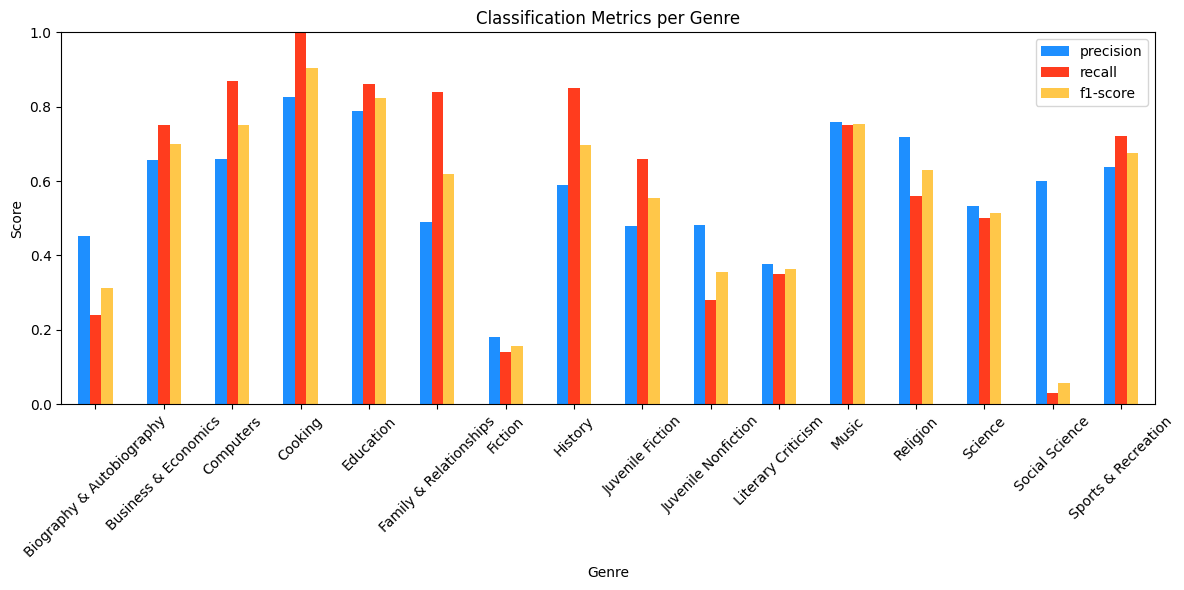

In [17]:
from sklearn.metrics import classification_report
import pandas as pd

# Get the classification report as a dictionary
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Convert to DataFrame for easier plotting
report_df = pd.DataFrame(report).transpose()

genre_metrics = report_df.iloc[:-3]

import matplotlib.pyplot as plt

# Plot precision, recall, F1 for each genre
custom_colors = ['#1e8fff','#ff3c1e','#ffc749']

genre_metrics[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6), color= custom_colors)
plt.title('Classification Metrics per Genre')
plt.xlabel('Genre')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()